In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh
from scipy.sparse import identity as sid
%matplotlib inline

# DUE 12/18/19, by 5:00 PM

**Problem 1**: (20pts) In quantum mechanics, it is really common to see boundary value problems of the form 

$$
-\epsilon\frac{d^{2}y}{dx^2} + \cos(\pi x)y = Ey, ~ y(-1) = y(1).
$$

where $0\leq \epsilon \ll 1$, i.e. we let $\epsilon$ be a small positive parameter.  $E\geq 0$ is the _energy_ of a particle trapped in an oscillating potential well $V(x) = \cos(\pi x)$, which is formed in crystal lattices of metals.  We likewise use _periodic-boundary conditions_ by setting 

$$
y(-1) = y(1).
$$

We desribe the probability of a particle being in the interval $[-1,a]$, $a<1$ via the formula

$$
P(-1\leq x \leq a) = \int_{-1}^{a} \tilde{y}(x), ~ \tilde{y}(x) = \frac{y^{2}(x)}{\int_{-1}^{1}y^{2}(x)dx}
$$

1a) Using second-order centered-difference approximations and spdiags, write code which discretizes the operator $-\epsilon\frac{d^{2}y}{dx^2} + \cos(\pi x)y\approx A{\bf y}$, where ${\bf y}=\left(y_{1} ~y_{2}\cdots y_{N-1}\right)^{T}$, $y_{j}=y(x_{j})$.  Note, the periodic boundary conditions are implemented as 

$$
y_{0} = y_{N-1}, ~ y_{N} = y_{1}.
$$

1b) You have now formed a discrete eigenvalue problem $A{\bf y} = E{\bf y}$.  Using the code below find the first 10 eigenvalues of the discretized equations.  For $\epsilon=1,.1,.01$ and $.001$, describe via a well designed plot how the first ten energy levels change as you decrease $\epsilon$.  

1c) For $\epsilon=.01$, compare the associated probability distributions $\tilde{y}(x)$ for the first three energy levels.  How do the likelihoods of where a particle would be found change with changing energy?   

In [2]:
#1A)

def Discretize (a, b, xvals, Nvals, fvals, epsilon):
    
    Nint = int(Nvals)
    dx = ( b - a ) / Nint
    idx2 = 1 / (dx ** 2)
    epsilon *= -1
    
    fvals[0] = fvals[Nint - 1]
    fvals [Nint] = fvals[1]
    
    ul = fvals[0]
    ur = fvals[Nint - 1]
    rhs = fvals[1 : Nint]
    rhs[0] -=  ul*idx2 
    rhs[Nint-2] -= ur*idx2 
    
    diag = -2 * epsilon * idx2 * np.ones( Nint - 1 )
    diag[0] *= 1/3
    diag[Nint - 2] *= 1/3
    
    diag += xvals[1 : Nint]
    odiag = epsilon * idx2 * np.ones( Nint-1 )
    
    data = np.array( [ diag, odiag, odiag] )
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, Nint-1, Nint-1)
    Tvec = spsolve(Amat,rhs)
    
    return Tvec

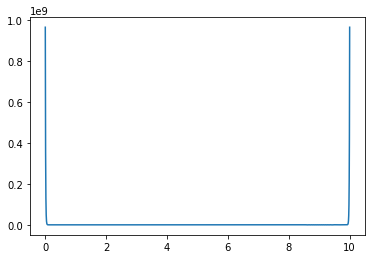

In [22]:
cosPI = lambda x : np.cos(np.pi * x)
fx = lambda x: np.exp(x)
a = 0
b = 10
Nvals = int(1e4)
epsilon = 1e-4
xvals = np.linspace(a,b,int(Nvals+1))
fvals = fx(xvals)

plt.plot( xvals[1:Nvals] ,Discretize(a,b, cosPI(xvals), Nvals,fvals,epsilon ) )

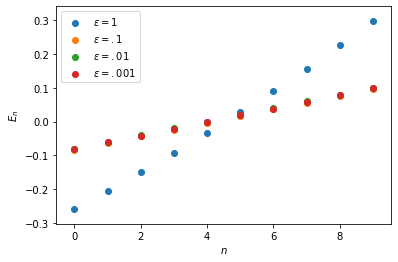

In [4]:
#1B)

def eval_find(Nvls,xvals,epvl):
    Nint = int(Nvls)
    dx = xvals[Nint-1] - xvals[0] / Nint
    idx2 = 1 / ( dx**2 )
    
    diag = -2 * epvl * idx2 * np.ones( Nint - 1 )
    diag[0] *= 1/3
    diag[Nint - 2] *= 1/3
    diag += xvals[1 : Nint]
    
    odiag = epvl * idx2 * np.ones( Nint-1 )
    odiag = epvl * idx2 * np.ones( Nint-1 )
    
    data = np.array( [ diag, odiag, odiag] )
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, Nint-1, Nint-1)
    eigenvalues, eigenvectors = eigsh(Amat,10,which='SM',mode='buckling')
   
    return eigenvalues # modify later to find appropriate eigenvectors 

Nvls = 100
xvals = np.linspace(-1.,1.,Nvls+1)

epsilon = 1
tprofile = eval_find(Nvls,xvals, epsilon)
plt.scatter(np.arange(tprofile.size),tprofile[:], label = '$\epsilon = 1$')

epsilon = .1
tprofile = eval_find(Nvls,xvals, epsilon)
plt.scatter(np.arange(tprofile.size),tprofile[:], label = '$\epsilon = .1$')

epsilon = .01
tprofile = eval_find(Nvls,xvals, epsilon)
plt.scatter(np.arange(tprofile.size),tprofile[:], label = '$\epsilon = .01$')

epsilon = .001
tprofile = eval_find(Nvls,xvals, epsilon)
plt.scatter(np.arange(tprofile.size),tprofile[:], label = '$\epsilon = .001$')



plt.xlabel("$n$")
plt.ylabel("$E_{n}$")
plt.legend(loc="best")


**Problem 2**: (20 pts) A more realistic way to describe the dynamics of temperature in a narrow corridor is via the _heat equation_, which is a partial differential equation describing how the temperature $T(x,t)$ changes in both space and time.  It is given by

$$
\frac{\partial T}{\partial t} = k \frac{\partial^{2}T}{\partial x^{2}}, ~ a\leq x \leq b
$$

where $k>0$ is the _thermal diffusion_ coefficient, and where we have the _oscillating_ boundary conditions 

$$
\left.\frac{\partial T(x,t)}{\partial x}\right|_{x=a} = \frac{1-\cos(t)}{2}
$$

and

$$
\left.\frac{\partial T(x,t)}{\partial x}\right|_{x=b} = -\sin(t), 
$$

representing two heat flux sources at either end of the domain, such as might arise from the motion of the Sun throughout the day, allowing for cooling on one side and heating on the other, with their roles switching as the Sun moves from East to West.  We likewise have the initial temperature distribution

$$
T(x,0) = u(x).
$$

To numerically solve this, letting $x_{j}= a + j\delta x$, $\delta x = (b-a)/N$

2a) Letting $T_{j}(t)=T(x_{j},t)$, show that the insulating boundary conditions are approximated by the finite-difference approximations:
$$
T_{0}(t) = \frac{2}{3}\left(2T_{1}(t)-\frac{1}{2}T_{2}(t)\right)-\frac{2\delta x}{3} \frac{(1-\cos(t))}{2}, ~ T_{N}(t) = \frac{2}{3}\left(2T_{N-1} - \frac{1}{2}T_{N-2}(t)\right)-\frac{2\delta x}{3} \sin(t).  
$$
(Note, see Homework Ten).  
2b) Using second-order centered-differencing approximations for the $\partial^{2}T/\partial{x^{2}}$ term, show that by discretizing in space, you get the following initial value problem

$$
\frac{d{\bf T}}{dt} = kA{\bf T}, ~ {\bf T}(t) = \begin{pmatrix} T_{1}(t) \\ T_{2}(t) \\ \cdots \\ T_{N-1}(t)\end{pmatrix}, ~ {\bf T}(0) = \begin{pmatrix} u(x_{1}) \\ u(x_{2}) \\ \cdots \\ u(x_{N-1})\end{pmatrix}
$$

where $A$ is some $(N-1)\times (N-1)$ sparse matrix.  What is $A$?  Is $A$ still symmetric?   

2c) Using the Trapezoid Method, we can discretize in time so that if we use time step $\delta t$, we get 

$$
\left(I - \frac{\delta t k}{2} A\right){\bf T}_{m+1} = \left(I + \frac{\delta t k}{2} A\right){\bf T}_{m} + \frac{\delta t k}{2}\left({\bf f}_{m+1} + {\bf f}_{m}\right),
$$

where 

$$
{\bf T}_{m} = {\bf T}(t_{m}) = \begin{pmatrix} T(x_{1},t_{m}) \\ T(x_{2},t_{m}) \\ \cdots \\ T(x_{N-1},t_{m})\end{pmatrix}
$$

and

$$
{\bf f}_{m} = \frac{2}{3\delta x}\begin{pmatrix} -(1-\cos(t_{m}))/2 \\ 0 \\ \vdots \\ 0 \\ -\sin(t_{m}) \end{pmatrix}
$$

Using the code snippet below implement the above scheme to solve the heat equation.  Using the initial heat distribution

$$
u(x) = e^{-(x-5)^{2}}, ~ 0\leq x \leq 10,
$$

generate several plots which show for $0\leq t \leq 10$ how changing the thermal diffusion paramter $k$ from $k=1,10,100$ changes the behavior of the temperature.  Explain your results and comment on any interesting phenomena. 

2A)
Let $BC$ = "Boundary Conditions"
\begin{align}
\frac{1}{\delta x} \left( \frac{-3}{2} T_{0,m} + 2 T_{1,m} -  \frac{1}{2} T_{2,m}\right) & \approx 0
\\
\frac{1}{\delta x} \left( \frac{-3}{2} T_{0,m} + 2 T_{1,m} -  \frac{1}{2} T_{2,m}\right) - BC & = 0
\\
\frac{-3}{2 \delta x} T_{0,m} + \frac {2}{\delta x} T_{1,m} -  \frac{1}{2 \delta x} T_{2,m} - BC & = 0
 \\
 \frac{3}{2 \delta x} T_{0,m} &=  \left( \frac {2}{\delta x} T_{1,m} -  \frac{1}{2 \delta x} T_{2,m}\right) - BC
 \\
 T_{0,m} &=  \frac {2}{3} \left( 2 T_{1,m} - \frac {1}{2} T_{2,m} \right) - \frac {2 \delta x}{3} BC
 \\
 BC \text{ at } T_0 &= \frac{1-\cos(t)}{2}
 \\
  T_{0,m} &=  \frac {2}{3} \left( 2 T_{1,m} - \frac {1}{2} T_{2,m} \right) - \frac {2 \delta x}{3} \frac{1-\cos(t)}{2}
  \\
 \end{align}
 
 Let $BC$ = "Boundary Conditions"
\begin{align}
\frac{-1}{\delta x} \left( \frac{-3}{2} T_{N,m} + 2 T_{N-1,m} -  \frac{1}{2} T_{N-2,m}\right) & \approx 0
\\
\frac{-1}{\delta x} \left( \frac{-3}{2} T_{N,m} + 2 T_{N-1,m} -  \frac{1}{2} T_{N-2,m}\right) - BC & = 0
\\
\frac{3}{2 \delta x} T_{N,m} - \frac {2}{\delta x} T_{N-1,m} + \frac{1}{2 \delta x} T_{N-2,m} - BC & = 0
 \\
 \frac{3}{2 \delta x} T_{N,m} &=  \left( \frac {2}{\delta x} T_{N-1,m} -  \frac{1}{2 \delta x} T_{N-2,m}\right) + BC
 \\
 T_{N,m} &=  \frac {2}{3} \left( 2 T_{N-1,m} - \frac {1}{2} T_{N-2,m} \right) + \frac {2 \delta x}{3} BC
 \\
 BC \text{ at } T_N &= -\sin (t)
 \\
  T_{N,m} &=  \frac {2}{3} \left( 2 T_{N-1,m} - \frac {1}{2} T_{N-2,m} \right) - \frac {2 \delta x}{3}\sin (t)
  \\
 \end{align}

2B)
Given A and $\frac{\delta T}{\delta t}$
\begin{align}
A &= \frac {1}{(\delta x)^2}
\begin{pmatrix} 
-2/3 &  & & & \\
& -2 & & & \\
& & \ddots & & \\
& & & -2 & \\
& & & & -2/3 \\
\end {pmatrix}
\\
\frac {\partial T }{\partial t} 
&= k \frac {\partial ^ 2 T}{\partial x ^ 2} 
\\\\
&= k \frac {1}{(\delta x)^2} \left( \frac{-2}{3}T_1 - 2 T_2 + ... + -2 T_{N-2} - \frac{2}{3} T_{N-1}  \right)
\\\\
&= k  \frac {1}{(\delta x)^2}
\begin{pmatrix} 
-2/3 &  & & & \\
& -2 & & & \\
& & \ddots & & \\
& & & -2 & \\
& & & & -2/3 
\end {pmatrix}
\begin{pmatrix}
T_1 \\
T_2 \\
\vdots \\
T_{N-2} \\
T_{N-1}
\end{pmatrix}
\\
&= kAT
\end{align}


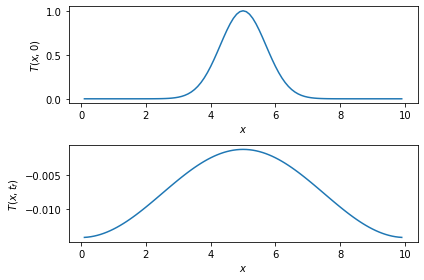

In [5]:
#2C)

def heat_eq_solver(k,u0,Nvls,dx,dt,t0,tf):    
    Nint = int(Nvls)
    nsteps = int(np.round((tf-t0)/dt))
    Tsol = np.zeros((Nvls-1,nsteps+1)) # build a matrix to store our solution 
    Tsol[:,0] = u0
    idx2 = 1./(dx**2.)
    diag = -2.*np.ones(Nvls-1)
    udiag = np.ones(Nvls-1)
    ldiag = np.ones(Nvls-1)
    diag[0] = -2/3
    diag[Nvls-2] = -2/3
    udiag[1] = 2/3
    ldiag[Nvls-3] = 2/3
    data = np.array([diag,ldiag,udiag])
    dvals = np.array([0,-1,1])
    Amat = idx2*spdiags(data, dvals, Nvls-1, Nvls-1)
    Lp = sid(Nvls-1) + dt*k*Amat/2.
    Lm = sid(Nvls-1) - dt*k*Amat/2.
    for mm in range(0,nsteps):
        fm = np.zeros(nsteps) 
        t = np.zeros(nsteps)
        t[mm] = t0 + dt
        t0 = t[mm]
        
        fm[0] = ( 2 / (3*dx) ) * ( -1*( 1 - np.cos(t[mm]) / 2 ) )
        fm[Nint - 2] = ( 2 / (3*dx) ) * ( - np.sin(t[mm]) )
        
        addTerm = (dt * k / 2) * (fm[mm] + fm[mm-1])
        Tsol[:,mm+1] = spsolve(Lm,Lp*Tsol[:,mm]+addTerm)
    return Tsol

Nvls = int(1e2)
xvals = np.linspace(0.,10.,Nvls+1)
xvalsc = xvals[1:Nvls]
dx = 10./Nvls
dt = 1e-1
t0 = 0.
tf = 10.
k = 1.
NT = int(np.round(tf/dt))

u0 = np.exp(-(xvals[1:Nvls]-5.)**2.)
Tsol = heat_eq_solver(k,u0,Nvls,dx,dt,t0,tf)

plt.subplot(2,1,1)
plt.plot(xvalsc,Tsol[:,0])
plt.xlabel('$x$')
plt.ylabel('$T(x,0)$')

plt.subplot(2,1,2)
plt.plot(xvalsc,Tsol[:,99])
plt.xlabel('$x$')
plt.ylabel('$T(x,t_{f})$')

plt.tight_layout()

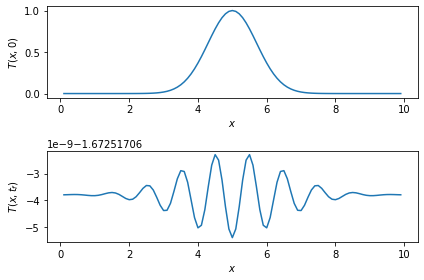

In [6]:
Nvls = int(1e2)
xvals = np.linspace(0.,10.,Nvls+1)
xvalsc = xvals[1:Nvls]
dx = 10./Nvls
dt = 1e-1
t0 = 0.
tf = 10.
k = 10
NT = int(np.round(tf/dt))

u0 = np.exp(-(xvals[1:Nvls]-5.)**2.)
Tsol = heat_eq_solver(k,u0,Nvls,dx,dt,t0,tf)

plt.subplot(2,1,1)
plt.plot(xvalsc,Tsol[:,0])
plt.xlabel('$x$')
plt.ylabel('$T(x,0)$')

plt.subplot(2,1,2)
plt.plot(xvalsc,Tsol[:,99])
plt.xlabel('$x$')
plt.ylabel('$T(x,t_{f})$')

plt.tight_layout()

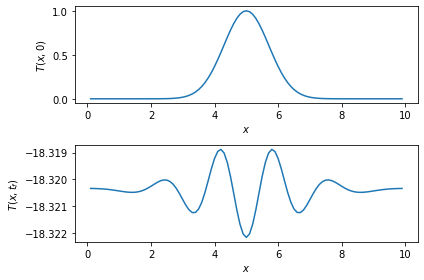

In [7]:
Nvls = int(1e2)
xvals = np.linspace(0.,10.,Nvls+1)
xvalsc = xvals[1:Nvls]
dx = 10./Nvls
dt = 1e-1
t0 = 0.
tf = 10.
k = 100
NT = int(np.round(tf/dt))

u0 = np.exp(-(xvals[1:Nvls]-5.)**2.)
Tsol = heat_eq_solver(k,u0,Nvls,dx,dt,t0,tf)

plt.subplot(2,1,1)
plt.plot(xvalsc,Tsol[:,0])
plt.xlabel('$x$')
plt.ylabel('$T(x,0)$')

plt.subplot(2,1,2)
plt.plot(xvalsc,Tsol[:,99])
plt.xlabel('$x$')
plt.ylabel('$T(x,t_{f})$')

plt.tight_layout()

**Problem 3** (10pts): A method for solving the matrix problem 

$$
A{\bf x} = {\bf b}
$$

where $A$ is an $n\times n$ matrix, and ${\bf x},{\bf b} \in \mathbb{R}^{n}$, goes as follows.  

* Write $A = D + R$, where $D$ is the diagonal of $A$, and $R= A-D$ is everything not on the diagonal of $A$.
* Given an initial choice of ${\bf x}_{0}$, define the iterative scheme 
$$
{\bf x}_{k+1} = D^{-1}\left({\bf b} - R{\bf x}_{k} \right), ~ k\geq 0.  
$$
* For a user defined tolerance $tol$, stop when 
$$
\left|\left|{\bf x}_{k+1} - {\bf x}_{k} \right|\right|_{2} < tol.  
$$

Given this method then, 

* Complete the code skeleton below.  
* Using the matrices generated by Problem 1, test your code on several different sized matrices, say where $n=10, ~100, ~200$.  Likewise choose ${\bf b}$ to be random vectors of size $10$, $100$, and $200$.  For the $tol$ values of $tol=10^{-4}$ and $tol=10^{-8}$, compare the results of your method to those you get using `spsolve`.  Do you see any variation in the accuracy of your results due to the change in size of the dimension of the problem?    
* For $n=200$, numerically determine the rate of convergence of this method, i.e. find $\alpha$ where
$$
\lim_{k\rightarrow \infty}\frac{\left|\left|{\bf x}_{k+1}-{\bf x}_{\ast}\right|\right|_{2}}{\left|\left|{\bf x}_{k}-{\bf x}_{\ast}\right|\right|^{\alpha}_{2}} = \lambda
$$
and where
$$
A{\bf x}_{\ast} \approx {\bf b},
$$
in other words ${\bf x}_{\ast}$ is the exact solution, or your best approximation to it.  

In [8]:
def iter_solver(A,b,x0,tol):
    Da = np.diag(A) # returns the diagonal entries of A as an array
    diag0 = np.zeros(Da.size - 1)
    data = np.array( [ Da, diag0, diag0] )
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, Da.size, Da.size)
    Rmat = A - Amat
    
    x1 = (b - np.matmul(Rmat,x0))/Da # I can just divide by an array, because that's all the inverse of a diagonal matrix really asks of us.
    x = np.array([x0,x1])
    while np.linalg.norm(x1-x0,2) >= tol: # the norm based tolerance condition, free of charge 
        x0 = x1
        x1 = (b - np.matmul(Rmat,x0))/Da
        x = np.append(x,x1)
    return x

btn = np.random.randn(10) # generate a random vector of 10 entries
bhn = np.random.randn(100) 
btwh = np.random.randn(200) 
# and I leave the rest to your capable hands.  
# It's been a great semester.  Have a great break and happy holidays. 